## Target Maximization

This section covers budget optimization by maximizing target with the insights from a fitted MMM.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning.optim import TargetMaximizer
from karpiu.planning.common import generate_cost_report
from karpiu.plots import ColorConstants

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [3]:
with open("./resource/seasonal/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [4]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()

In [5]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    variance_penalty=0.0,
    # response_scaler=10.0,
)
optim_spend_df = maximizer.optimize(maxiter=5000)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -41124.81052156184
            Iterations: 493
            Function evaluations: 76951
            Gradient evaluations: 493


In [6]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [7]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 453606
Total Budget: 453606


### Budget Allocation

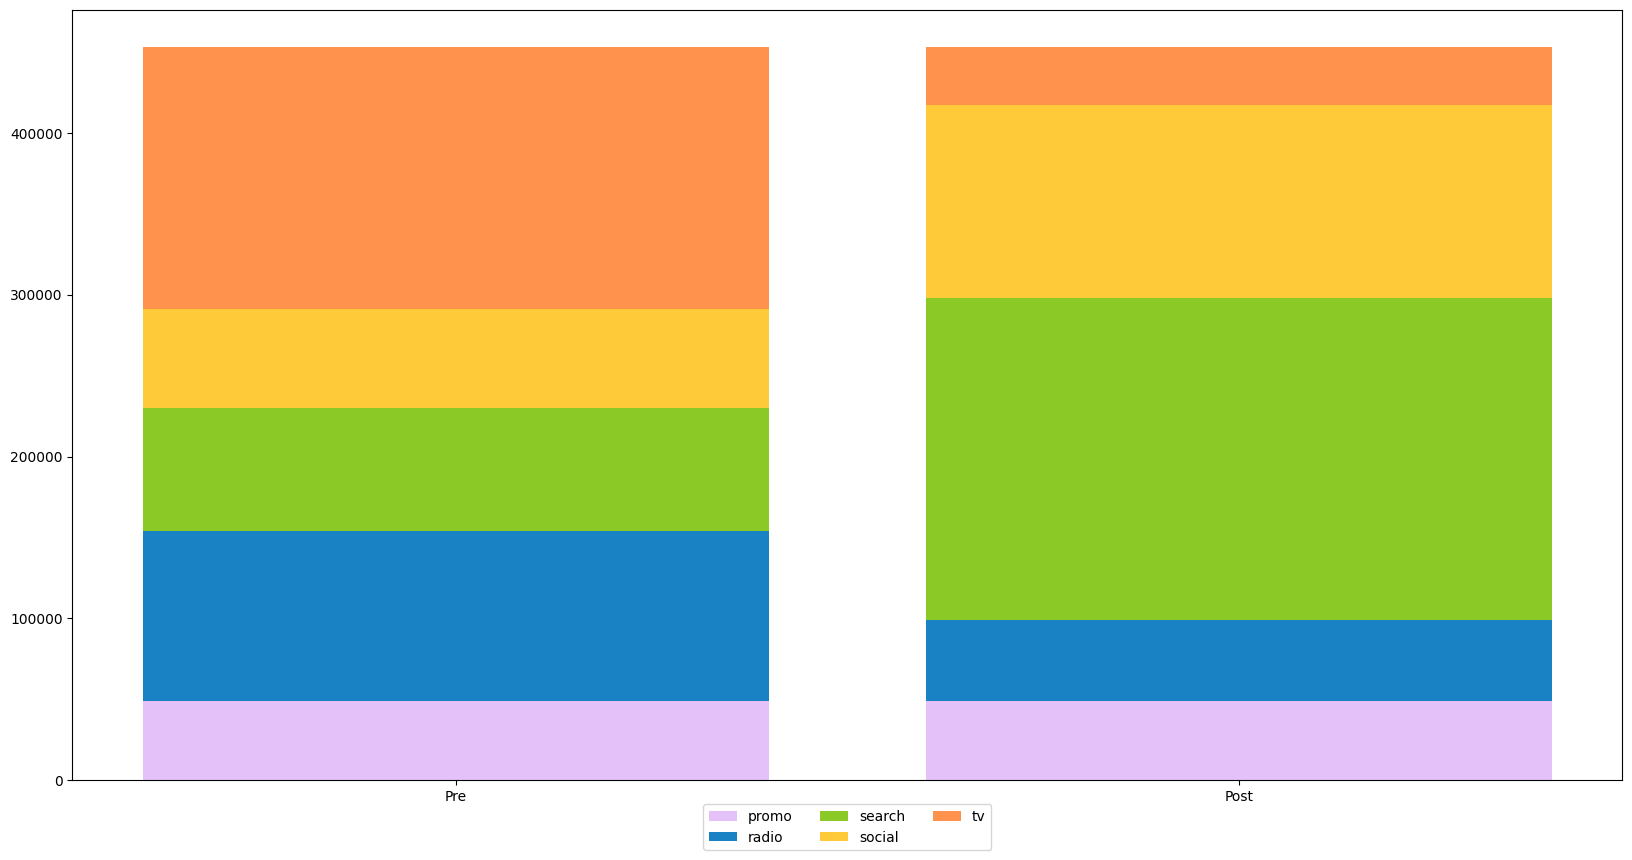

In [8]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(
        x=["Pre", "Post"],
        height=plot_data[:, idx],
        bottom=bottom,
        label=label,
        color=ColorConstants.RAINBOW_SIX[idx],
    )
    bottom += plot_data[:, idx]
# ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Average and Marginal Cost Change

In [9]:
df = mmm.get_raw_df()

In [11]:
cost_report = generate_cost_report(
    model=mmm,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
    method="additive",
)
cost_report

2023-12-10 15:13:18 - karpiu-planning - INFO - Full calculation start=2021-01-01 and end=2021-01-31
2023-12-10 15:13:18 - karpiu-planning - INFO - Attribution start=2021-01-01 and end=2021-01-31
2023-12-10 15:13:18 - karpiu-planning - INFO - Full calculation start=2021-01-01 and end=2021-01-31
2023-12-10 15:13:18 - karpiu-planning - INFO - Attribution start=2021-01-01 and end=2021-01-31


,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,pre-opt-attr,post-opt-attr
promo,44.57775,32.00855,47.59562,49.31798,48.64000,49.00586,1091.12732,1531.02402
radio,76.23849,34.81708,56.48530,51.82603,105.58500,49.86311,1384.93044,1432.14523
search,29.39121,29.25783,25.48650,43.41038,75.70300,199.44081,2575.70174,6816.66359
social,33.89162,28.68790,27.00025,45.02274,61.33200,119.26722,1809.65100,4157.40470
tv,97.31447,39.20080,90.79573,55.69172,162.34600,36.02899,1668.26161,919.08801


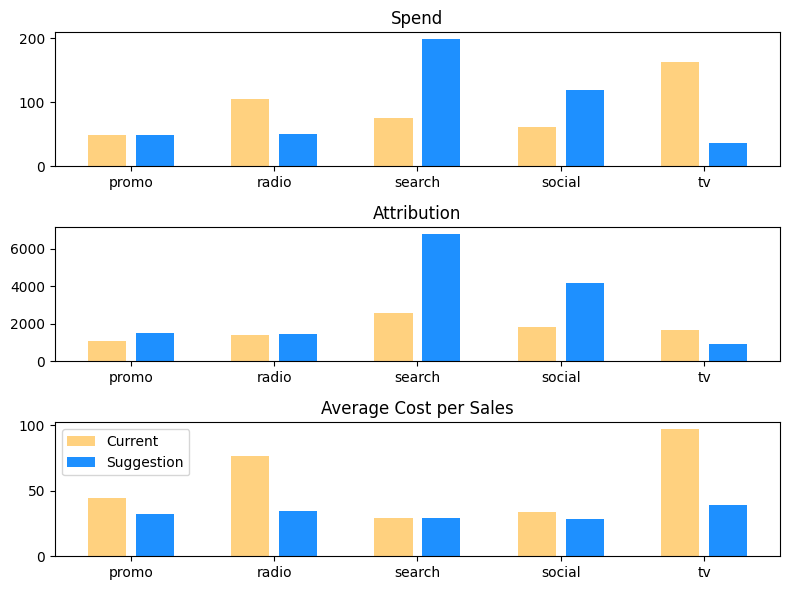

In [12]:
# TODO: figure out the y-axis unit

fig, ax = plt.subplots(3, 1, figsize=(8, 6))
# spend
ax[0].bar(
    x=np.arange(0, 3 * len(optim_channels), 3),
    height=cost_report["pre-opt-spend"],
    color="orange",
    alpha=0.5,
    label="Current",
)
ax[0].bar(
    x=np.arange(1, 3 * len(optim_channels) + 1, 3),
    height=cost_report["post-opt-spend"],
    color="dodgerblue",
    label="Suggestion",
)
ax[0].set_xticks(0.5 + np.arange(0, 3 * len(optim_channels), 3))
ax[0].set_xticklabels(optim_channels)
# ax[0].legend()
ax[0].set_title("Spend")

# Attribution
ax[1].bar(
    x=np.arange(0, 3 * len(optim_channels), 3),
    height=cost_report["pre-opt-attr"],
    color="orange",
    alpha=0.5,
    label="Current",
)
ax[1].bar(
    x=np.arange(1, 3 * len(optim_channels) + 1, 3),
    height=cost_report["post-opt-attr"],
    color="dodgerblue",
    label="Suggestion",
)
ax[1].set_xticks(0.5 + np.arange(0, 3 * len(optim_channels), 3))
ax[1].set_xticklabels(optim_channels)
# ax[1].legend()
ax[1].set_title("Attribution")

# Efficiency
ax[2].bar(
    x=np.arange(0, 3 * len(optim_channels), 3),
    height=cost_report["pre-opt-avg-cost"],
    color="orange",
    alpha=0.5,
    label="Current",
)
ax[2].bar(
    x=np.arange(1, 3 * len(optim_channels) + 1, 3),
    height=cost_report["post-opt-avg-cost"],
    color="dodgerblue",
    label="Suggestion",
)
ax[2].set_xticks(0.5 + np.arange(0, 3 * len(optim_channels), 3))
ax[2].set_xticklabels(optim_channels)
ax[2].legend()
ax[2].set_title("Average Cost per Sales")

fig.tight_layout()

### Outcome Plot

In [13]:
df = mmm.get_raw_df()
optim_pred = mmm.predict(optim_spend_df)
init_pred = mmm.predict(df)

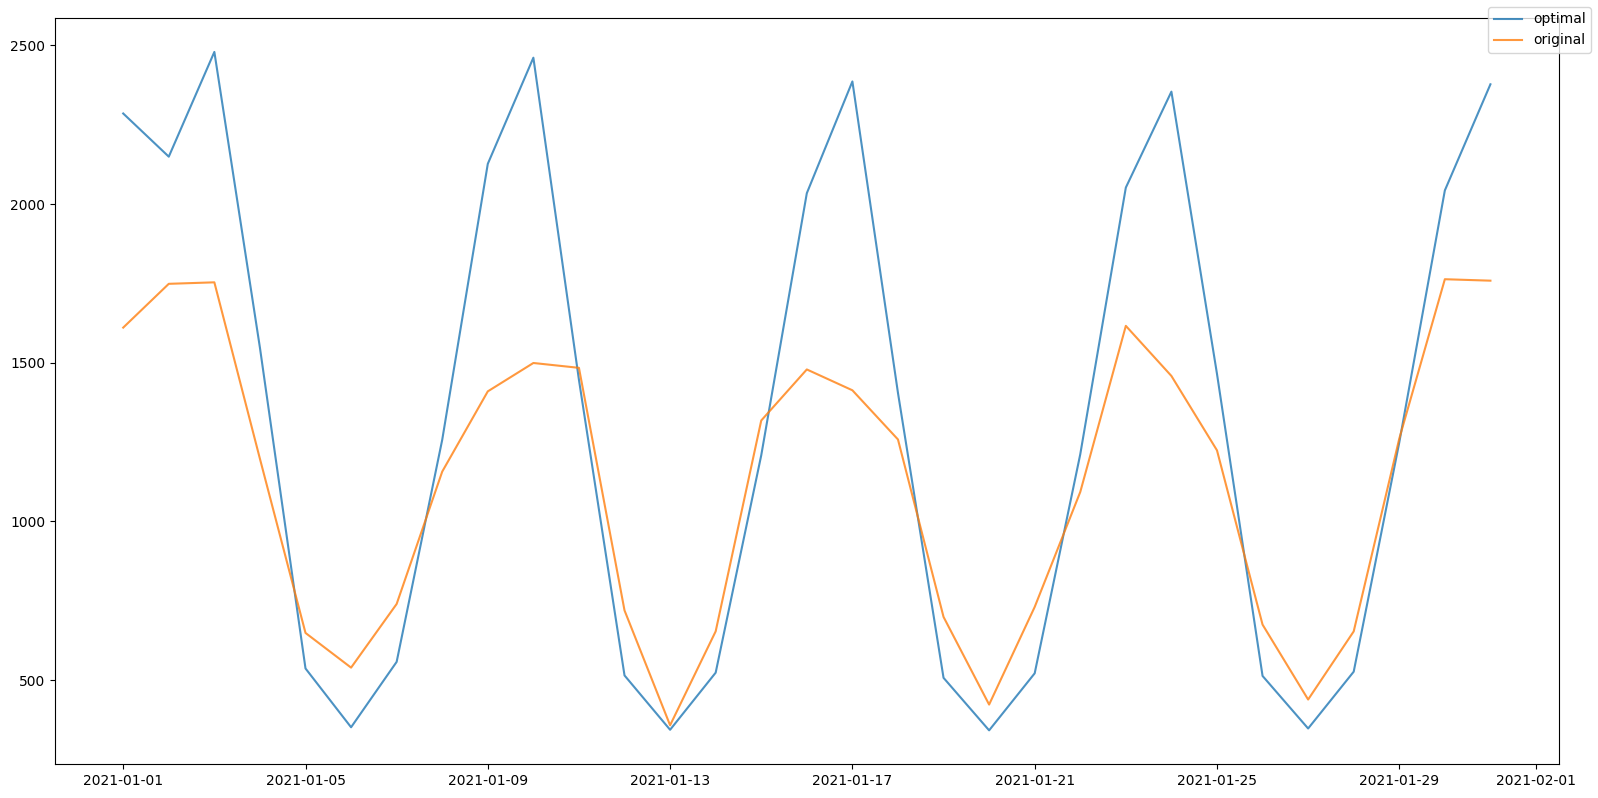

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(
    optim_pred.loc[maximizer.result_mask, "date"].values,
    optim_pred.loc[maximizer.result_mask, "prediction"].values,
    label="optimal",
    alpha=0.8,
)
ax.plot(
    init_pred.loc[maximizer.result_mask, "date"].values,
    init_pred.loc[maximizer.result_mask, "prediction"].values,
    label="original",
    alpha=0.8,
)
fig.legend()
fig.tight_layout();

In [15]:
# check2: total predicted response must be higher than current
total_optim_pred = np.sum(optim_pred.loc[maximizer.result_mask, "prediction"].values)
total_init_pred = np.sum(init_pred.loc[maximizer.result_mask, "prediction"].values)
assert total_optim_pred > total_init_pred

### Cost Curve

In [16]:
from karpiu.planning.cost_curves import CostCurves

In [17]:
cc = CostCurves(
    model=mmm,
    n_steps=10,
    curve_type="individual",
    extend_multiplier=1.05,
)
cc.generate_cost_curves()
cc_optim = CostCurves(
    model=mmm,
    n_steps=10,
    curve_type="individual",
    spend_df=optim_spend_df,
    extend_multiplier=1.05,
)
cc_optim.generate_cost_curves()

2023-12-10 15:13:32 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:32 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:34 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:34 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

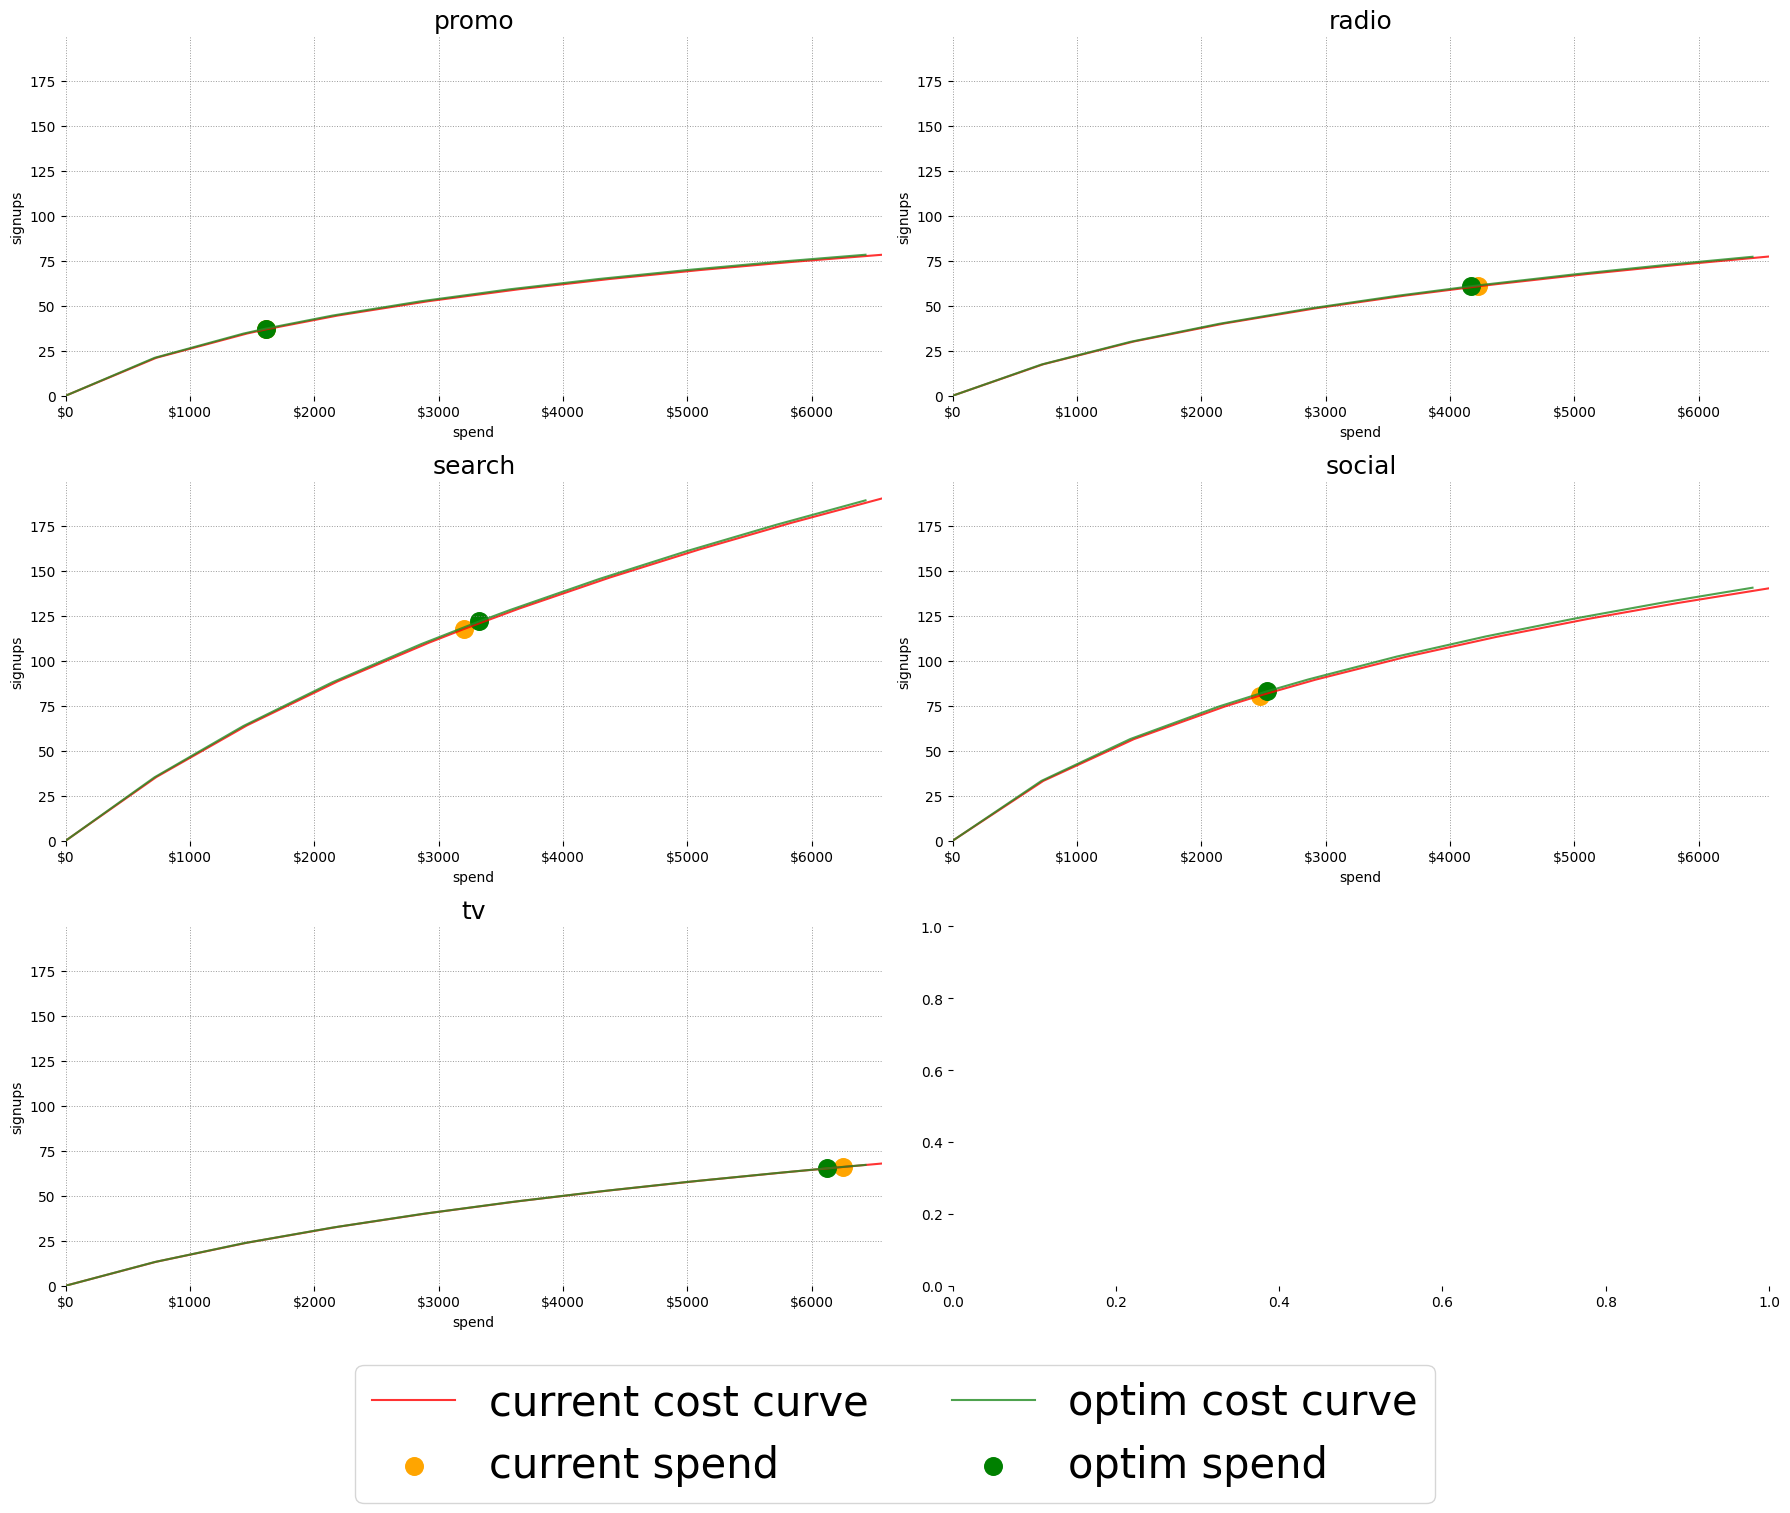

In [18]:
cc.plot(optim_cost_curves=cc_optim.cost_curves, include_organic=False);

The following code block is to create animation of the optimization process along the cost curve.

In [19]:
xs = maximizer.get_callback_metrics()["xs"]
fig_paths = list()

idx_seq = np.round(np.linspace(0, len(xs) - 1, 10)).astype(int)
for idx in idx_seq:
    x = xs[idx]
    x = x.reshape(-1, maximizer.n_optim_channels) * maximizer.spend_scaler
    # build a temporary spend_df
    temp_df = mmm.get_raw_df()
    temp_df.loc[maximizer.budget_mask, optim_channels] = x

    cc = CostCurves(
        model=mmm,
        n_steps=10,
        curve_type="individual",
        extend_multiplier=1.05,
    )
    cc.generate_cost_curves()
    cc_optim = CostCurves(
        model=mmm,
        n_steps=10,
        curve_type="individual",
        spend_df=temp_df,
        extend_multiplier=1.05,
    )
    cc_optim.generate_cost_curves()
    axes = cc.plot(
        optim_cost_curves=cc_optim.cost_curves, include_organic=False, is_visible=False
    )
    fig = axes[0].get_figure()
    
    fig_path = "./demo_optim_output/png/fig_{:07d}.png".format(idx)
    fig_paths.append(fig_path)
    fig.savefig(fname=fig_path)
    
import imageio
with imageio.get_writer(
    "./demo_optim_output/optim.gif", mode="I", duration=500
) as writer:
    for fig_path in fig_paths:
        image = imageio.imread(fig_path)
        writer.append_data(image)

2023-12-10 15:13:38 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:38 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:40 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:40 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:42 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:42 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:45 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:45 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:47 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:47 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:50 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:50 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:52 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:52 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:54 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:54 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:57 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:57 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:13:59 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:13:59 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:02 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:02 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:04 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:04 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:07 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:07 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:09 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:09 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:12 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:12 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:14 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:14 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:17 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:17 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:19 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:19 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:22 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:22 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-10 15:14:24 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 15:14:24 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]